In [1]:
%load_ext autoreload
%autoreload 2
%cd /home/florian/GitRepos/activeCell-ACDC
!ls

import json
import random as rd
import matplotlib.image as mpimg
import cv2
import wandb
import torch
import os
import logging
import pandas as pd
import collections
import matplotlib.pyplot as plt
import seaborn as sns

from detectron2.utils.visualizer import Visualizer
from detectron2.utils.logger import setup_logger
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor
from detectron2.checkpoint import DetectionCheckpointer

from src.globals import *
from utils.visualization.show_image import show_image, plot_prediction
from utils.register_datasets import register_datasets, get_dataset_name
from utils.config_builder import get_config
from utils.notebook_utils import *
from utils.evaluation import SingleImageCOCOEvaluator


from src.test import do_test
from src.active_learning.al_trainer import *
from src.active_learning.mc_dropout_sampler import *
from src.active_learning.tta_sampler import *


logger = setup_logger(output="./log/main.log",name="null_logger") 
logger.addHandler(logging.NullHandler())
logging.getLogger('detectron2').setLevel(logging.WARNING)
logging.getLogger('detectron2').addHandler(logging.NullHandler())

[Errno 2] No such file or directory: '/home/florian/GitRepos/activeCell-ACDC'
/mnt/activeCell-ACDC/experiments
__pycache__		     mc_drop_notebook.ipynb	  train_model_subset.py
get_aps.py		     mc_drop_stability.py	  tta_gridsearch.py
latent_vis.ipynb	     mc_drop_train_vs_test.ipynb  tta_notebook.ipynb
mc_drop_aggregation.py	     object_detection.ipynb	  tta_stability.ipynb
mc_drop_gridsearch.py	     results			  tta_stability.py
mc_drop_known_vs_unknown.py  stability.ipynb		  uncertainty.py


/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'src'

In [2]:
dataset = ACDC_LARGE_CLS
test_dataset_name = dataset + "_test_slim"
config_name = "final_random_al"

model_path = "/home/florian/GitRepos/activeCell-ACDC/output/acdc_large_gs_cls/model_training"

In [3]:
register_datasets()
train_data = DatasetCatalog.get(get_dataset_name(
    dataset, DATASETS_DSPLITS[dataset][0]
))

test_data = DatasetCatalog.get(test_dataset_name)

registering acdc_large dataset
registering acdc_large_cls dataset


In [4]:
wandb.init(
    project="activeCell-ACDC",
    name="",
    sync_tensorboard=True,
    mode="disabled",
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [5]:
default_cfg = get_config(config_name)
cfg = default_cfg
cfg.OUTPUT_DIR = "./al_output/classes_acdc_large_al"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4
#cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.2
#cfg.TEST.DETECTIONS_PER_IMAGE = 50

In [6]:
model = load_model(cfg, os.path.join(model_path, "best_model.pth"))

In [9]:
results = do_test(cfg, model=model, logger=logger)

/home/florian/GitRepos/activeCell-ACDC/ac_acdc_env/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.397
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.881
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.172
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.406
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.417
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.192
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.089
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.437
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.480
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.458
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.506
 Average Recall     (AR) @[ IoU=0.50:0.

In [10]:
results

OrderedDict([('segm',
              OrderedDict([('AP', 80.9461068369123),
                           ('AP50', 88.92707718249858),
                           ('AP75', 85.65054781757304),
                           ('APs', 79.9229744682973),
                           ('APm', 85.77473947363569),
                           ('APl', 72.84233959831064),
                           ('AP-G1', 80.9010398712661),
                           ('AP-mother', 91.00394136603175),
                           ('AP-bud', 70.93333927343906)])),
             ('bbox',
              OrderedDict([('AP', 39.695430490930526),
                           ('AP50', 88.11735936100843),
                           ('AP75', 17.240059472533698),
                           ('APs', 40.607132171752234),
                           ('APm', 41.66738211912757),
                           ('APl', 19.205634690824358),
                           ('AP-G1', 40.29952548890598),
                           ('AP-mother', 43.2775274192499

In [11]:
cfg_tmp = cfg
cfg_tmp.DATASETS.TEST = ("acdc_large_cls_train",)
train_results = do_test(cfg_tmp, model=model, logger=logger)
train_results

Loading and preparing results...
DONE (t=0.06s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.408
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.910
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.422
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.416
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.349
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.087
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.423
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.478
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.513
 Average Recall     (AR) @[ IoU=0.50:0.

OrderedDict([('segm',
              OrderedDict([('AP', 83.50731675671322),
                           ('AP50', 91.47679749314025),
                           ('AP75', 87.99889621842667),
                           ('APs', 82.04040646403432),
                           ('APm', 88.04482250737867),
                           ('APl', 87.1510443856235),
                           ('AP-G1', 82.87000648533126),
                           ('AP-mother', 93.48589562262629),
                           ('AP-bud', 74.16604816218211)])),
             ('bbox',
              OrderedDict([('AP', 40.81750319278133),
                           ('AP50', 90.9918573277388),
                           ('AP75', 16.34112541683419),
                           ('APs', 42.178037579060124),
                           ('APm', 41.56992377879705),
                           ('APl', 34.87490028000675),
                           ('AP-G1', 41.41121053041126),
                           ('AP-mother', 44.05438960705087)

In [7]:
evaluator = SingleImageCOCOEvaluator(test_dataset_name, cfg, False,output_dir="./" )
val_loader = build_detection_test_loader(cfg, test_dataset_name)

#Use the created predicted model in the previous step
res = inference_on_dataset(model, val_loader, evaluator)


/home/florian/GitRepos/activeCell-ACDC/ac_acdc_env/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.600
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.500
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.600
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.600
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.600
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.600
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.600
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50

In [8]:
res

{'TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0': OrderedDict([('bbox',
               {'AP': 60.0,
                'AP50': 100.0,
                'AP75': 50.0,
                'APs': 60.0,
                'APm': nan,
                'APl': nan,
                'AP-G1': nan,
                'AP-mother': 50.0,
                'AP-bud': 70.0}),
              ('segm',
               {'AP': 95.0,
                'AP50': 100.0,
                'AP75': 100.0,
                'APs': 95.0,
                'APm': nan,
                'APl': nan,
                'AP-G1': nan,
                'AP-mother': 100.0,
                'AP-bud': 90.0})]),
 'TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_102': OrderedDict([('bbox',
               {'AP': 49.11441144114412,
                'AP50': 91.74917491749174,
                'AP75': 28.1078107810781,
                'APs': 49.11441144114412,
                'APm': nan,
                'APl': nan,
                'AP-G1': 52.524752475247524,
    

In [71]:
segm_ap_dict = [
    {
        "image_id": key,
        "segm_ap": res[key]["segm"]["AP"],
        "AP-G1": res[key]["segm"]["AP-G1"],
        "AP-mother": res[key]["segm"]["AP-mother"],
        "AP-bud": res[key]["segm"]["AP-bud"],
    } for key in res.keys()
]

In [72]:
df = pd.DataFrame.from_records(segm_ap_dict).sort_values("segm_ap")
df.head()

image_id    segm_ap       AP-G1  AP-mother  \
92        acdc_data2_F016_pos_3_18   0.000000    0.000000    0.00000   
119       acdc_data2_F016_pos_3_90  30.214521   90.643564    0.00000   
234  acdc_data3_20210722_pos_18_39  33.333333  100.000000    0.00000   
120       acdc_data2_F016_pos_3_93  37.010844   77.369165   30.29703   
108       acdc_data2_F016_pos_3_60  38.729373    0.000000   75.00000   

        AP-bud  
92    0.000000  
119   0.000000  
234   0.000000  
120   3.366337  
108  41.188119

In [11]:
df.tail().values

array([['acdc_data2_kurt_306-3_0_20201028_pos_1_42', 100.0],
       ['acdc_data2_kurt_306-3_0_20201028_pos_1_3', 100.0],
       ['TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_3', 100.0],
       ['TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_45', 100.0],
       ['acdc_data3_20211029_pos_1_24', 100.0]], dtype=object)

acdc_data2_F016_pos_3_18 segm_ap: 0.0


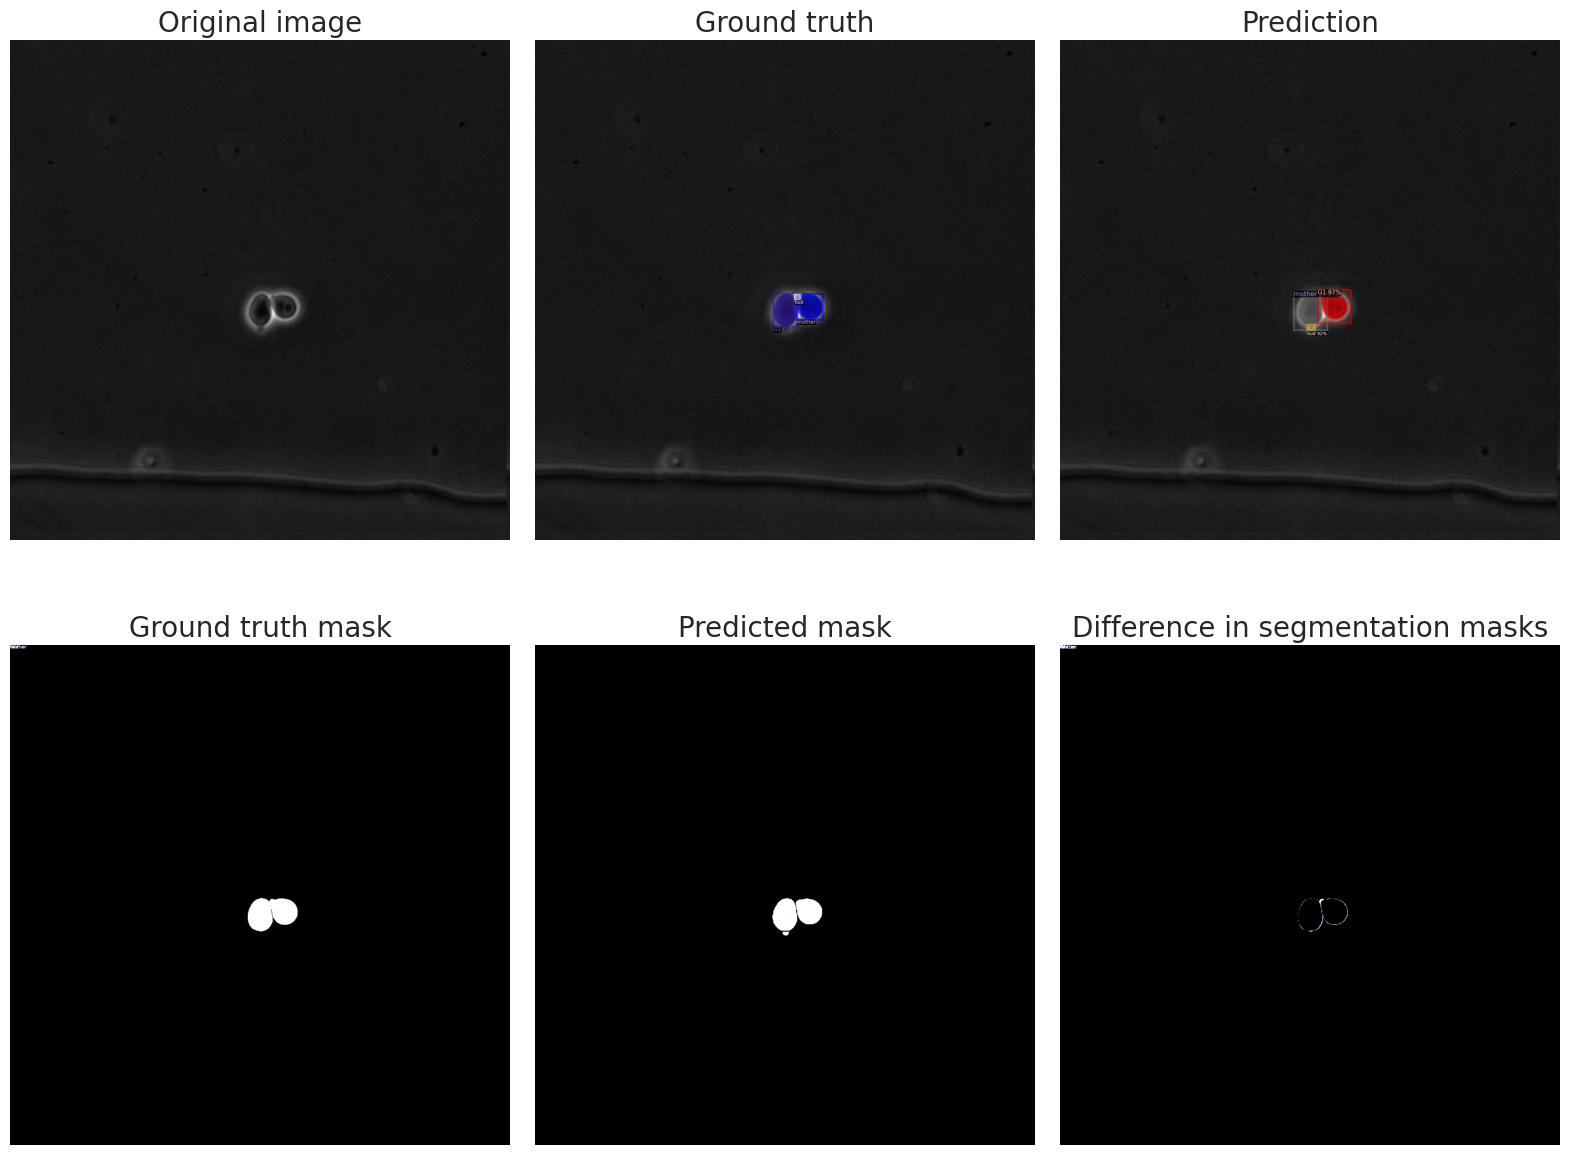

acdc_data2_F016_pos_3_90 segm_ap: 30.214521452145217


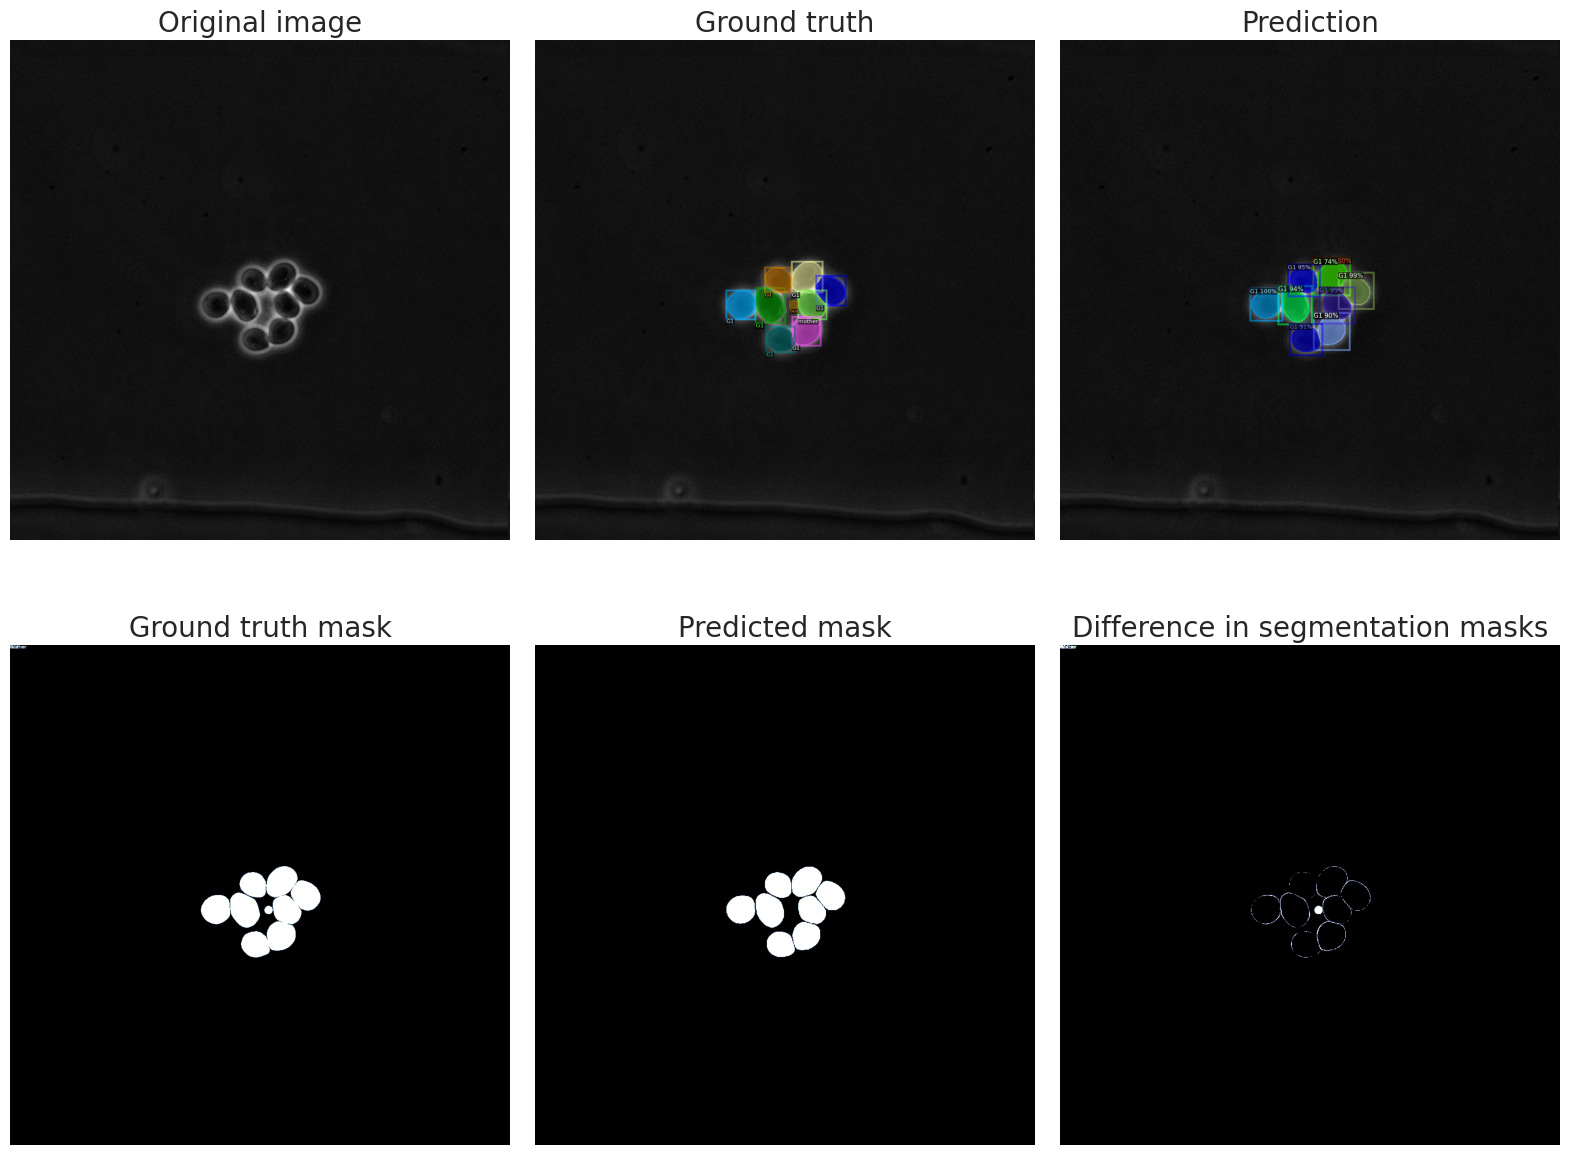

acdc_data3_20210722_pos_18_39 segm_ap: 33.33333333333333


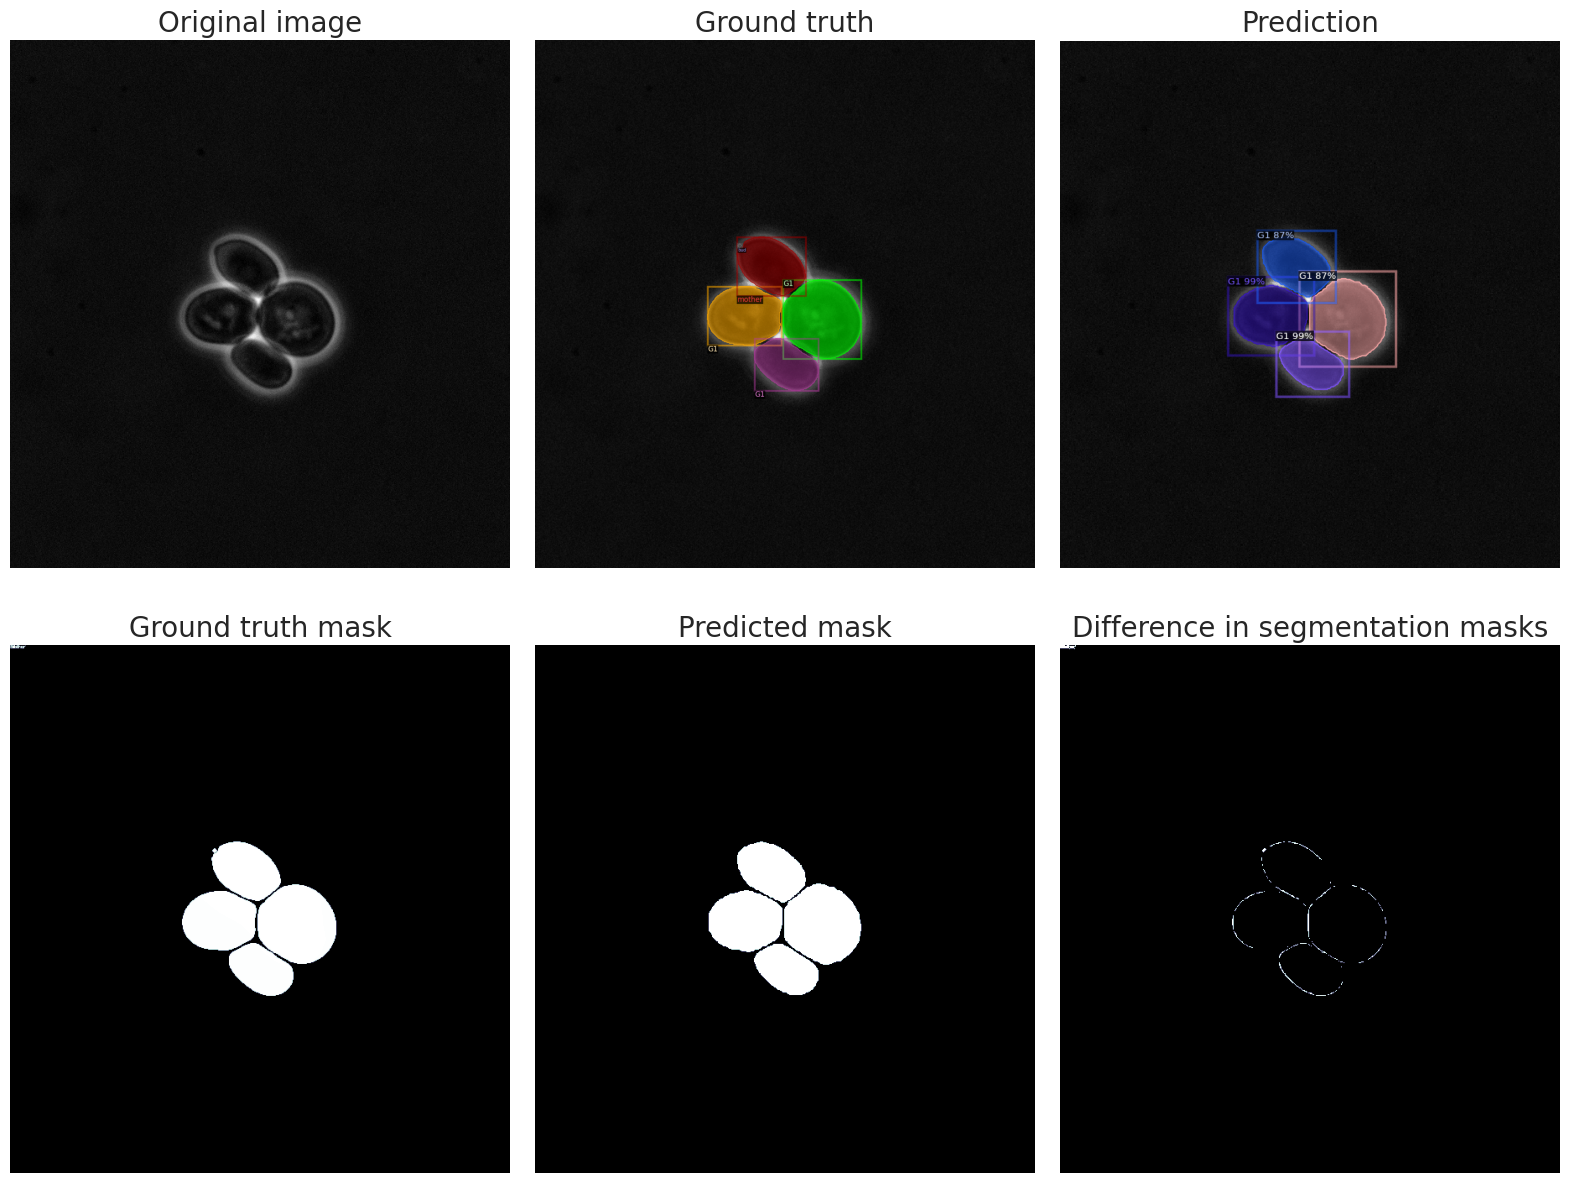

acdc_data2_F016_pos_3_93 segm_ap: 37.01084394153701


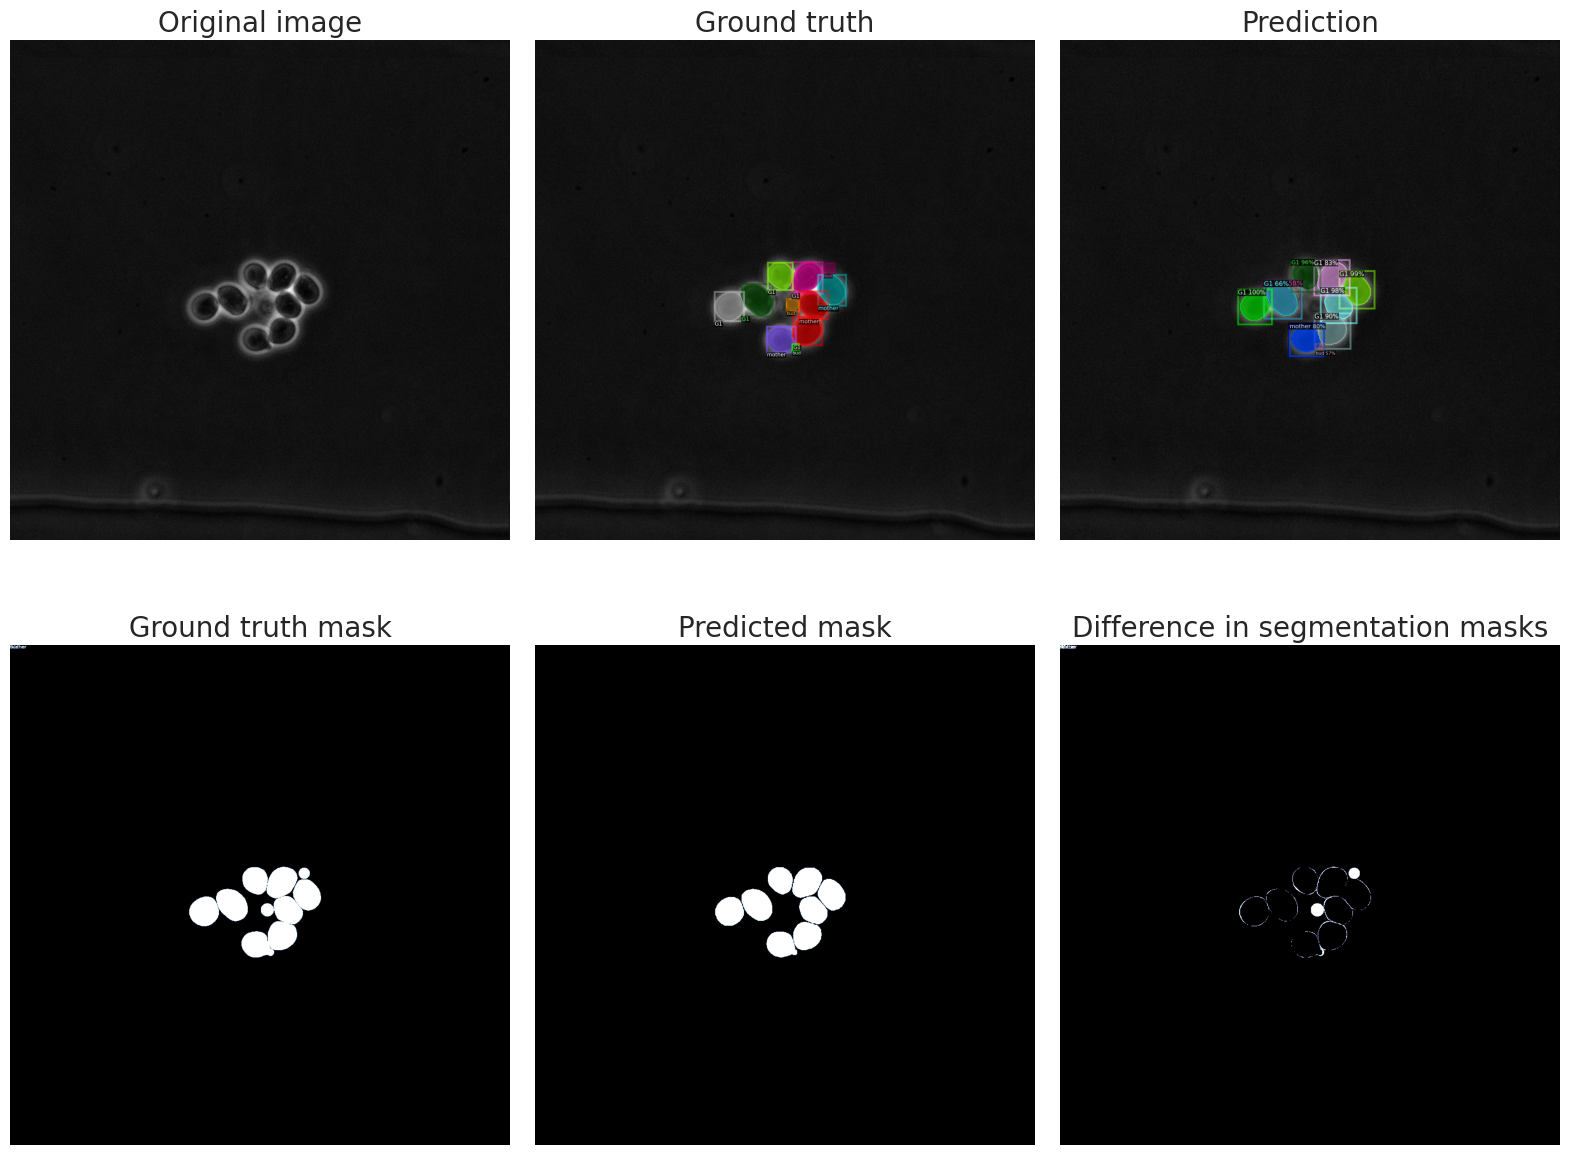

acdc_data2_F016_pos_3_60 segm_ap: 38.729372937293725


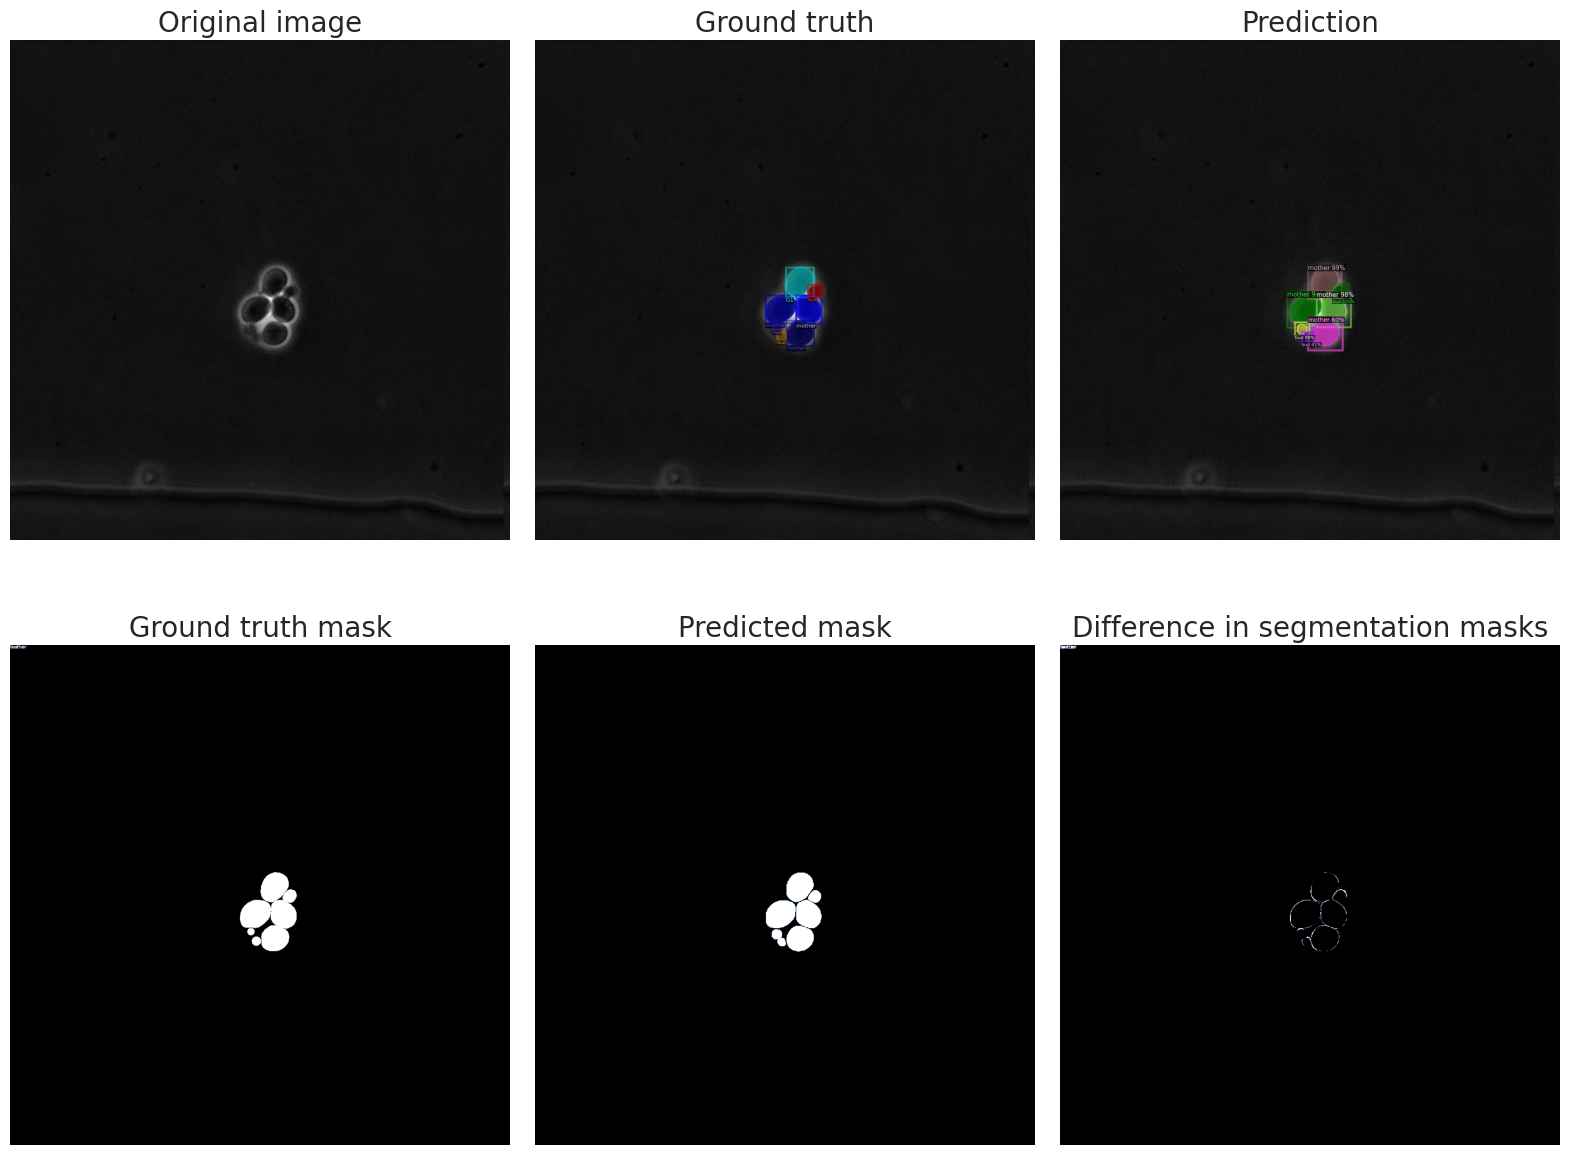

In [118]:
for record in df.head().values:
    image_id = record[0]
    segm_ap = record[1]
    print(f"{image_id} segm_ap: {segm_ap}")

    image_json = get_json_by_id(image_id, test_data)  

    plot_prediction(image_json, test_dataset_name, cfg, model_path=os.path.join(model_path, "best_model.pth"))

acdc_data2_kurt_306-3_0_20201028_pos_1_42 segm_ap: 100.0


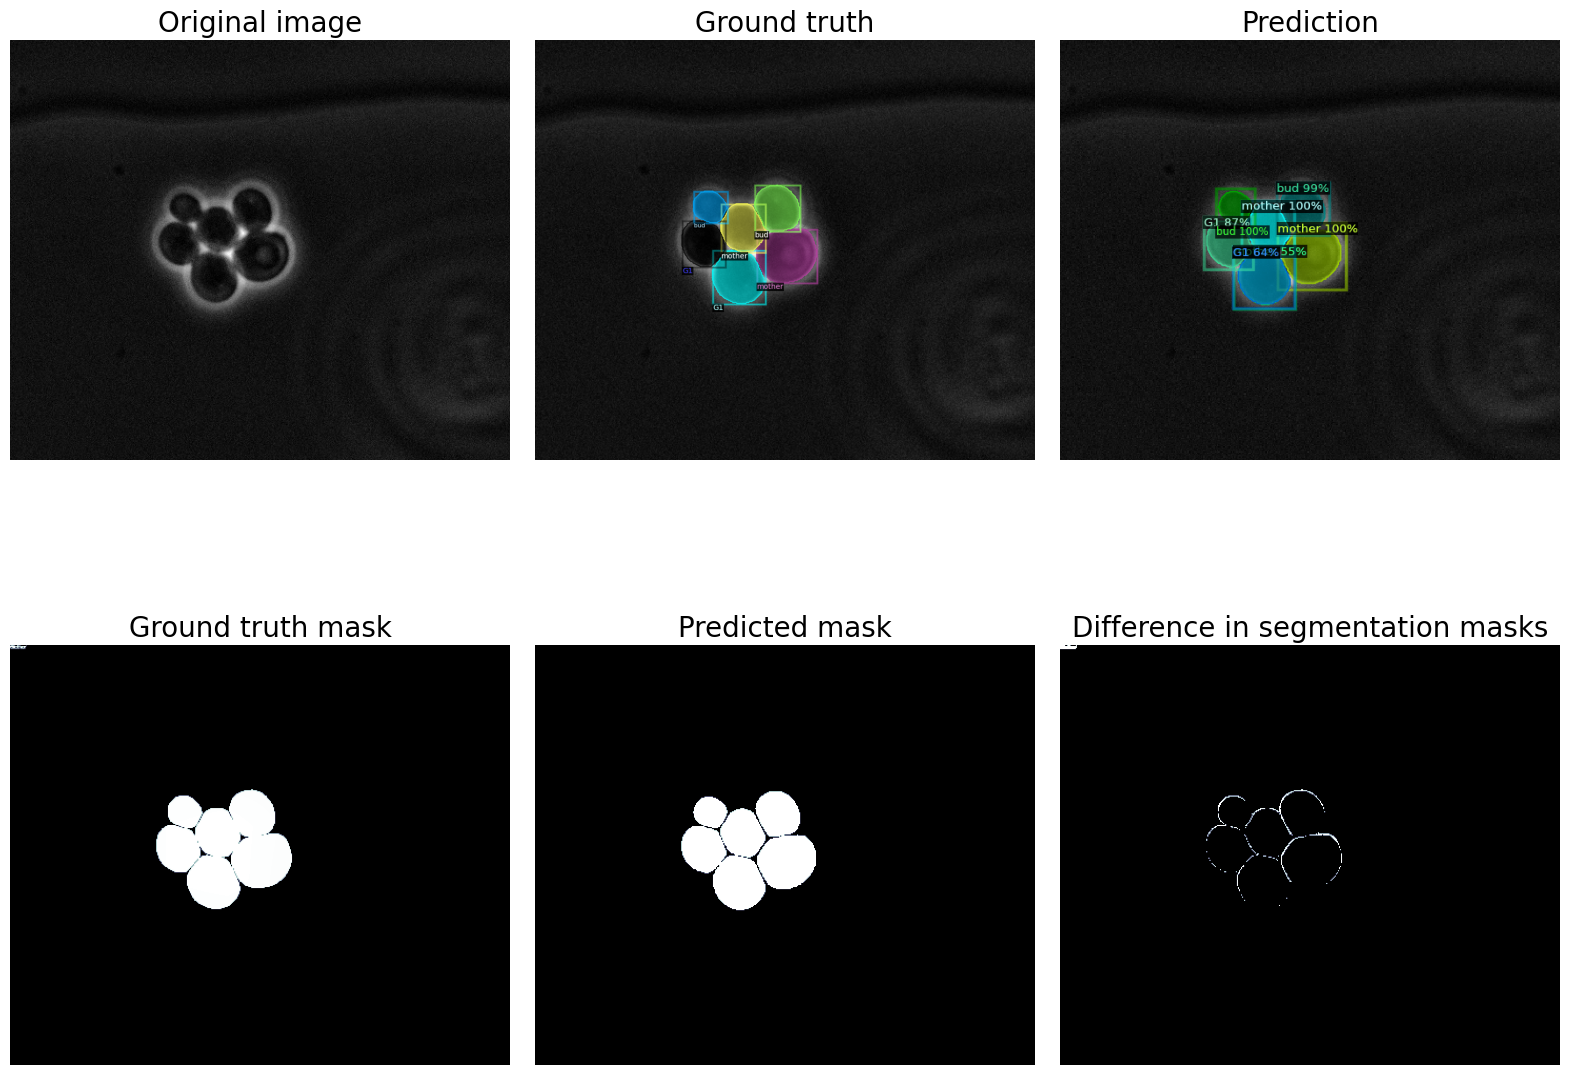

acdc_data2_kurt_306-3_0_20201028_pos_1_3 segm_ap: 100.0


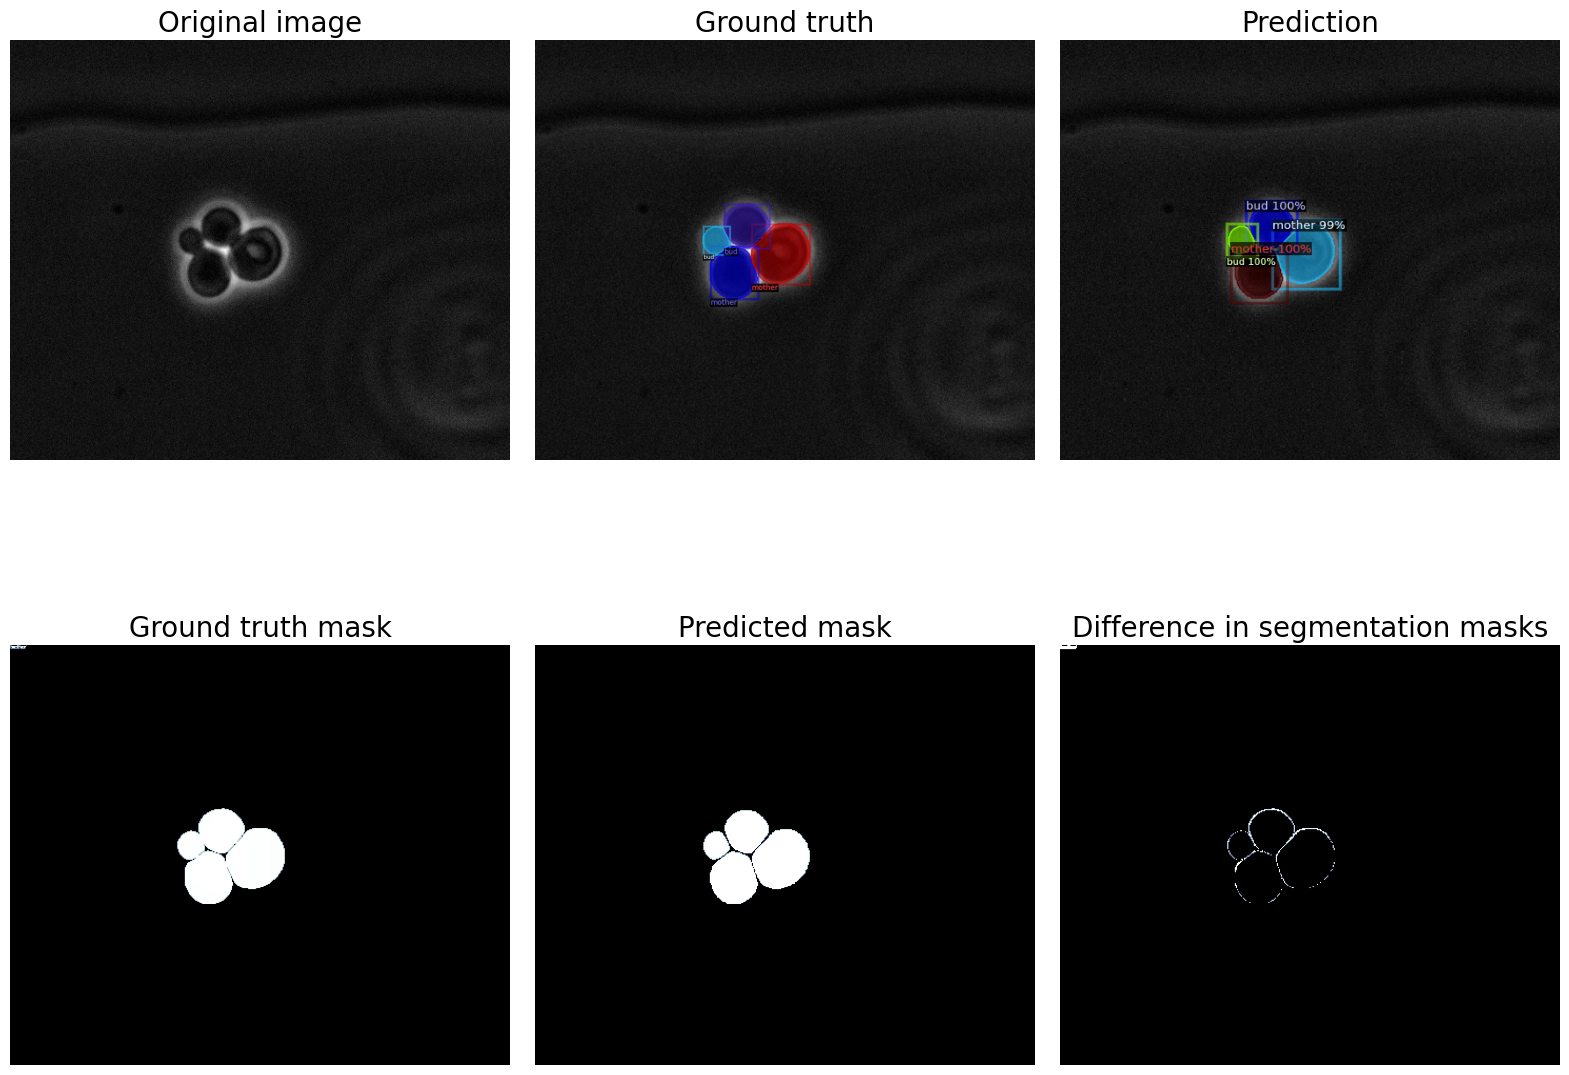

TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_3 segm_ap: 100.0


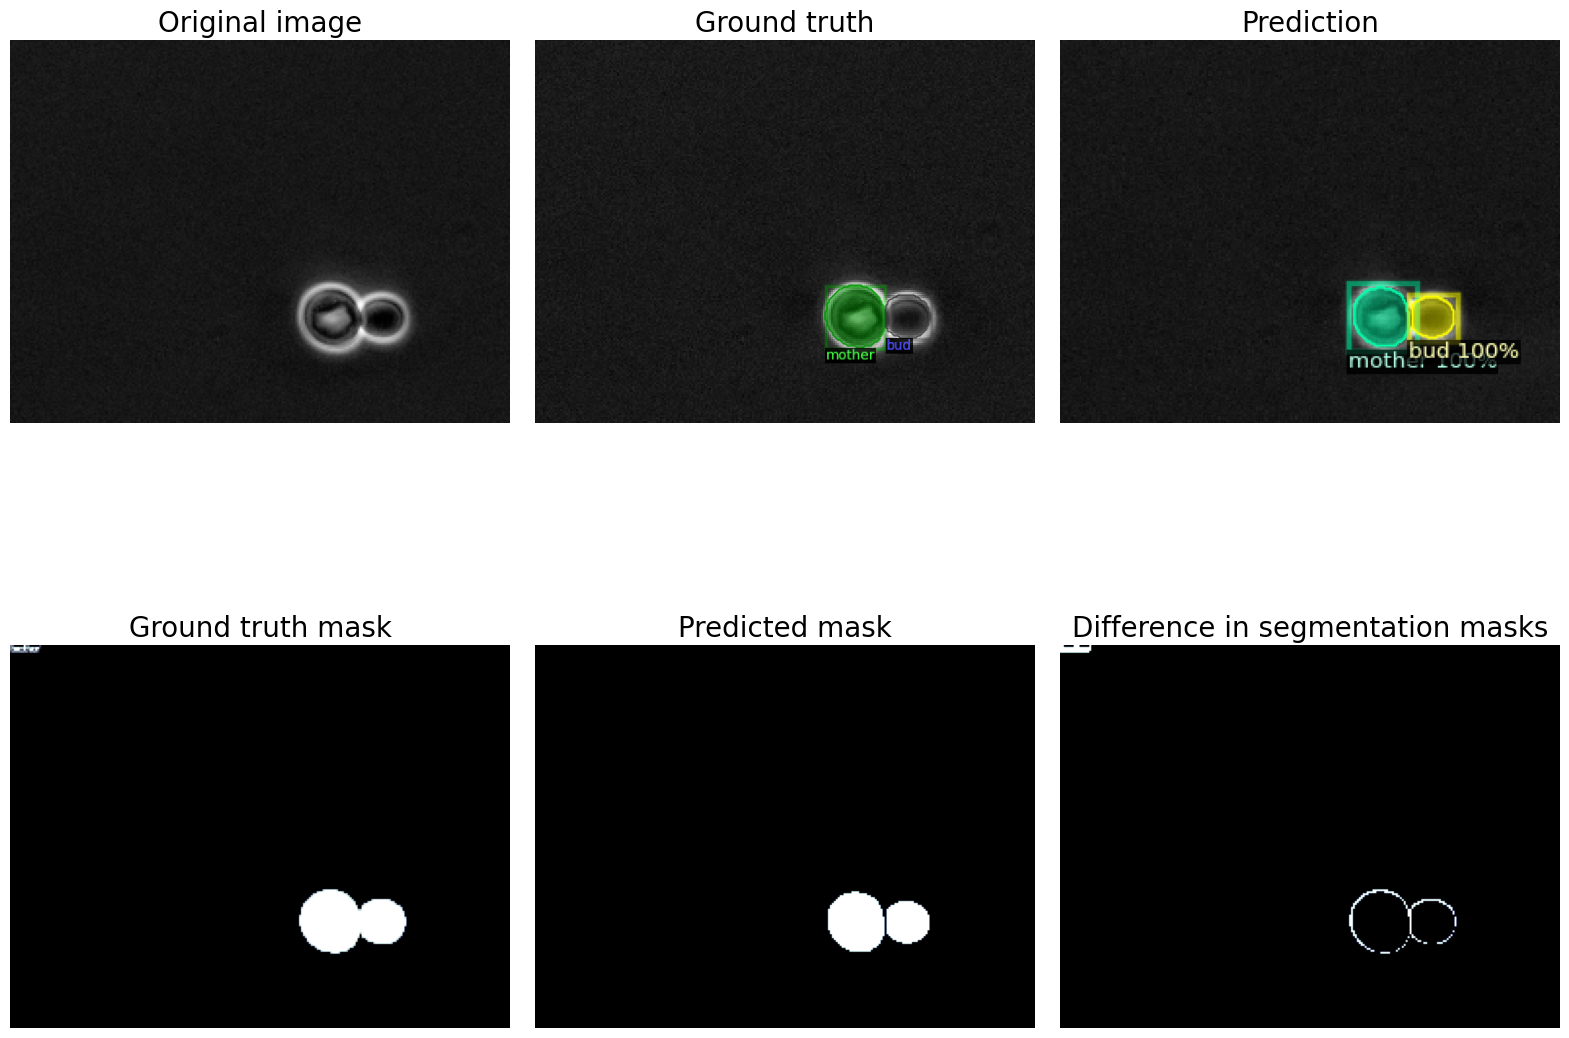

TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_45 segm_ap: 100.0


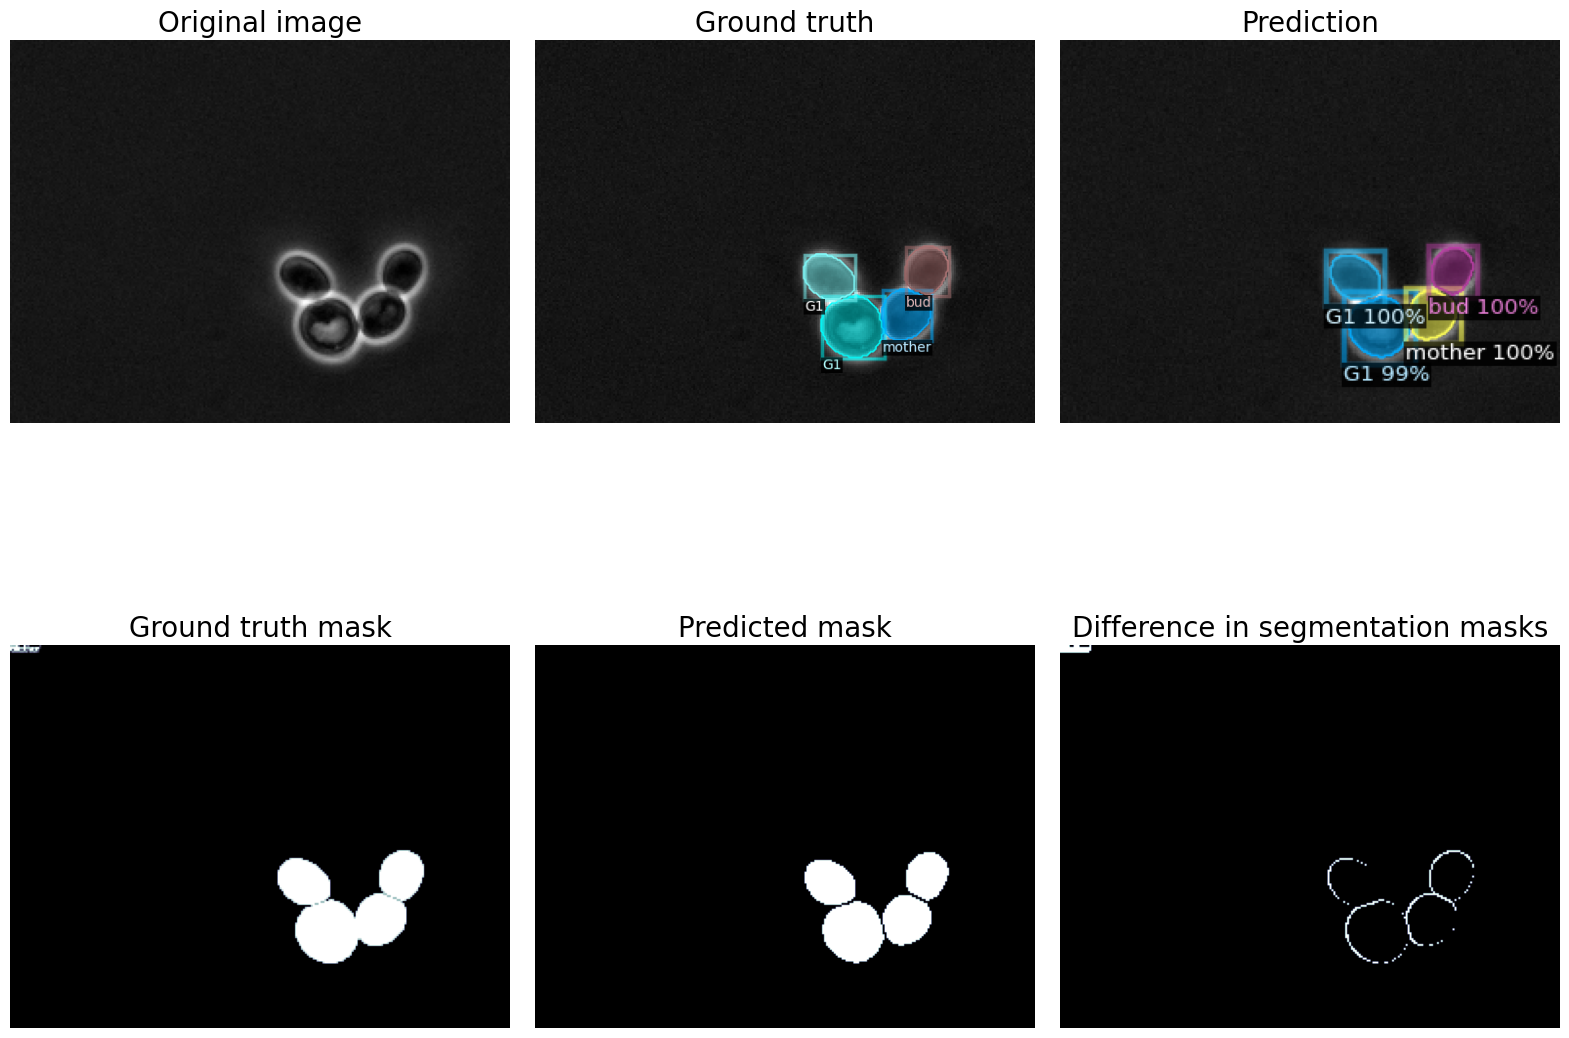

acdc_data3_20211029_pos_1_24 segm_ap: 100.0


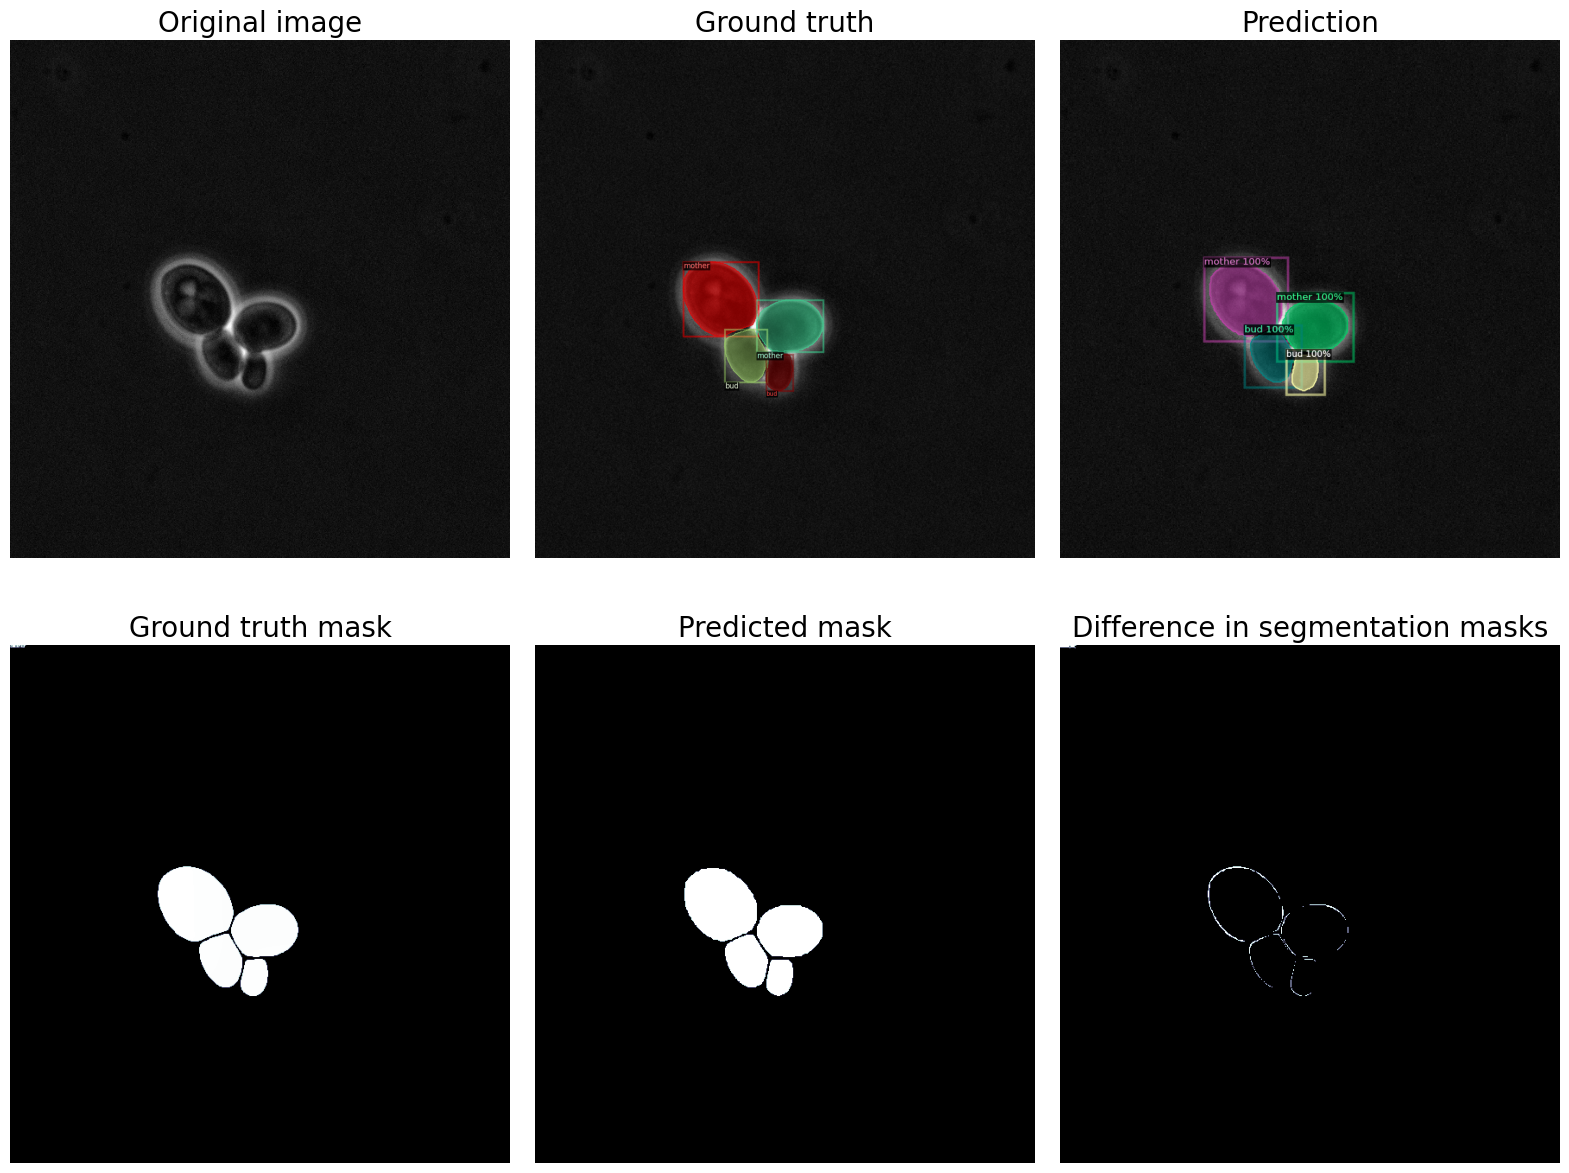

In [26]:
for record in df.tail().values:
    image_id = record[0]
    segm_ap = record[1]
    print(f"{image_id} segm_ap: {segm_ap}")

    image_json = get_json_by_id(image_id, test_data)  

    plot_prediction(image_json, test_dataset_name, cfg, model_path=os.path.join(model_path, "best_model.pth"))
    
    
    

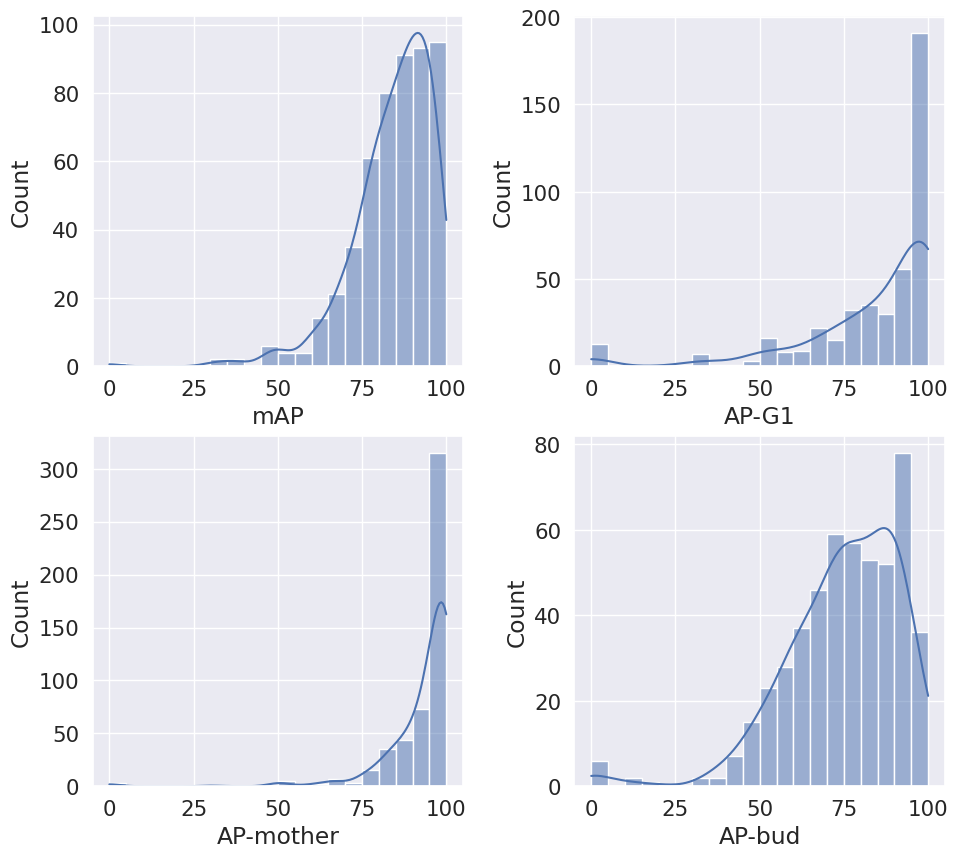

In [117]:

df["mAP"] = df["segm_ap"] 

fig, axs = plt.subplots(2, 2, figsize=(11, 10))
sns.set(font_scale=1.4)
sns.histplot(data=df, x="mAP", label="mAP", kde=True, ax=axs[0, 0], stat="count", binwidth=5)
sns.histplot(data=df, x="AP-G1", label="AP-G1", kde=True, ax=axs[0, 1], stat="count", binwidth=5)
sns.histplot(data=df, x="AP-mother", label="AP-mother", kde=True, ax=axs[1, 0], stat="count", binwidth=5)
sns.histplot(data=df, x="AP-bud", label="AP-bud", kde=True, ax=axs[1, 1], stat="count", binwidth=5)
fig.subplots_adjust(wspace=0.3)

In [34]:
df

image_id     segm_ap         mAP
92                            acdc_data2_F016_pos_3_18    0.000000    0.000000
119                           acdc_data2_F016_pos_3_90   30.214521   30.214521
234                      acdc_data3_20210722_pos_18_39   33.333333   33.333333
120                           acdc_data2_F016_pos_3_93   37.010844   37.010844
108                           acdc_data2_F016_pos_3_60   38.729373   38.729373
..                                                 ...         ...         ...
168          acdc_data2_kurt_306-3_0_20201028_pos_1_42  100.000000  100.000000
163           acdc_data2_kurt_306-3_0_20201028_pos_1_3  100.000000  100.000000
53   TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_3  100.000000  100.000000
59   TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_...  100.000000  100.000000
377                       acdc_data3_20211029_pos_1_24  100.000000  100.000000

[509 rows x 3 columns]

In [38]:

df["num_objects"] = df["image_id"].map(lambda x: len(get_json_by_id(x, test_data)['annotations']))



In [39]:
df

image_id     segm_ap  \
92                            acdc_data2_F016_pos_3_18    0.000000   
119                           acdc_data2_F016_pos_3_90   30.214521   
234                      acdc_data3_20210722_pos_18_39   33.333333   
120                           acdc_data2_F016_pos_3_93   37.010844   
108                           acdc_data2_F016_pos_3_60   38.729373   
..                                                 ...         ...   
168          acdc_data2_kurt_306-3_0_20201028_pos_1_42  100.000000   
163           acdc_data2_kurt_306-3_0_20201028_pos_1_3  100.000000   
53   TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_3  100.000000   
59   TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_...  100.000000   
377                       acdc_data3_20211029_pos_1_24  100.000000   

            mAP  num_objects  
92     0.000000            3  
119   30.214521            9  
234   33.333333            5  
120   37.010844           11  
108   38.729373            7  
..          ...          ...  
168  100.000000            6  
163  100.000000            4  
53   100.000000            2  
59   100.000000            4  
377  100.000000            4  

[509 rows x 4 columns]

In [67]:
bins = range(0,61,10)
df['Number of Objects'] = pd.cut(df['num_objects'], bins)